# XGBoost for EMPO_1, EMPO_2, EMPO_3

### Imports

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
import pandas as pd
import numpy as np

# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time

### Load training data and labels

In [4]:
x_train = get_training_observations()
y_train = get_training_labels()

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [36]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [31]:
y_train['EMPO_3'].value_counts()

Soil (non-saline)          303
Water (saline)             290
Water (non-saline)         245
Subsurface (non-saline)    144
Plant rhizosphere           96
Sediment (non-saline)       73
Animal proximal gut         39
Hypersaline (saline)        15
Sediment (saline)           14
Aerosol (non-saline)         8
Plant surface                6
Surface (saline)             6
Surface (non-saline)         5
Animal corpus                4
Plant corpus                 1
Name: EMPO_3, dtype: int64

### Data manipulation

Encode labels and store LabelEncoder() instance in a dictionay.

In [5]:
# print(y_tr.columns)
lc_dict = {}
for label in y_train.columns:
#     print(label)
    lc_dict[label] = LabelEncoder()
#     print(lc_dict)
    y_train[label] = lc_dict[label].fit_transform(y_train[label])
#     print(y_train)
#     print(lc_dict[label].inverse_transform(y_tr[label]))
print(lc_dict)

{'EMPO_1': LabelEncoder(), 'EMPO_2': LabelEncoder(), 'EMPO_3': LabelEncoder()}


Validation splits

In [6]:
# Split into train/validation if not CV
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

Convert to DMatrix for more efficient XGB if using xgb.train instead of xgb.XGBClassifier

In [7]:
train_dmat = xgb.DMatrix(x_tr, label=y_tr)
test_dmat = xgb.DMatrix(x_val, label=y_val)

### Model training

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


<AxesSubplot:>

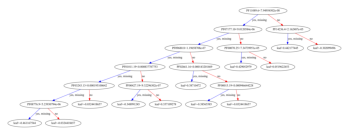

In [127]:
# empo_1 model
empo1_model = xgb.XGBClassifier(objective='binary:logistic')
empo1_model.fit(x_tr,y_tr['EMPO_1'])
print(empo1_model)
# plot single tree
plot_tree(empo1_model, num_trees=1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


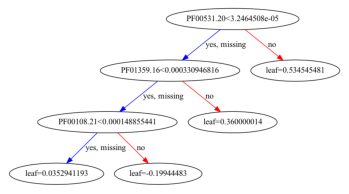

In [129]:
empo2_model = xgb.XGBClassifier(objective='multi:softprob')
empo2_model.fit(x_tr,y_tr['EMPO_2'])
print(empo2_model)
# plot single tree
plot_tree(empo2_model)
plt.show()

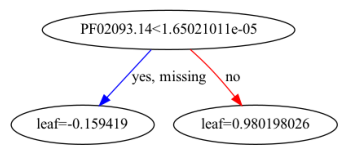

In [139]:
empo3_model = xgb.XGBClassifier(objective='multi:softprob')
empo3_model.fit(x_tr,y_tr['EMPO_3'])
print(empo3_model)
# plot single tree
plot_tree(empo3_model)
plt.show()

### Model evaluation

In [141]:
empo1_pred = empo1_model.predict(x_val)
print("Training Set Accuracy Score on EMPO 1: ", accuracy_score(y_val['EMPO_1'], empo1_pred))
empo2_pred = empo2_model.predict(x_val)
print("Training Set Accuracy Score on EMPO 2: ", accuracy_score(y_val['EMPO_2'], empo2_pred))
empo3_pred = empo3_model.predict(x_val)
print("Training Set Accuracy Score on EMPO 3: ", accuracy_score(y_val['EMPO_3'], empo3_pred))

Training Set Accuracy Score on EMPO 1:  0.992
Training Set Accuracy Score on EMPO 2:  0.992
Training Set Accuracy Score on EMPO 3:  0.928


### Model Tuning
For work here are the hyperparameters we usually try:
* max_depth: integers from 8 to 20
* min_child_weight: integers from 1 to 100
* lambda/reg_lambda: log scaling .001 to 1
* alpha/reg_alpha: log scaling .001 to 10
* gamma: float between 0 and 4
* learning_rate: log scaling .01 to 1
* subsample: float between 0.2 and 1
* colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1

There are obviously a ton of different possible combinations here, so we use gridSearch pick the more important ones to test. I would just set learning rate at 0.01 and try changing the max_depth & min_child_weight parameters first.

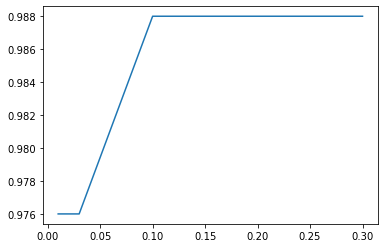

In [170]:
def empo1_eta_results(learning_rates):
    results = {'learning_rate': [], 'accuracy':[]}
    for learning_rate in learning_rates:
        empo1_model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=learning_rate)
        empo1_model.fit(x_tr,y_tr['EMPO_1'])
        empo1_pred = empo1_model.predict(x_val)
        results['learning_rate'].append(learning_rate)
        results['accuracy'].append(accuracy_score(y_val['EMPO_1'], empo1_pred))
    results = pd.DataFrame(results)
    return results
learning_rates = [0.01,0.03,0.1,0.3]
results = empo1_eta_results(learning_rates)
plt.plot(results['learning_rate'], results['accuracy'])
plt.show()

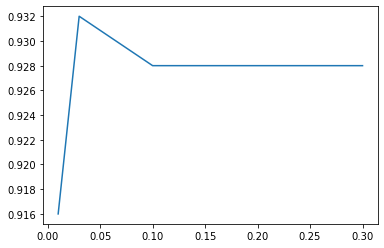

In [173]:
def eta_results(empo, objective, learning_rates):
    results = {'learning_rate': [], 'accuracy':[]}
    for learning_rate in learning_rates:
        model = xgb.XGBClassifier(objective=objective, learning_rate=learning_rate)
        model.fit(x_tr,y_tr[empo])
        y_pred = model.predict(x_val)
        results['learning_rate'].append(learning_rate)
        results['accuracy'].append(accuracy_score(y_val[empo], y_pred))
    results = pd.DataFrame(results)
    return results

learning_rates = [0.01,0.03,0.1,0.3]
results = eta_results(empo='EMPO_3', 
                      objective='multi:softprob', 
                      learning_rates=learning_rates)
plt.plot(results['learning_rate'], results['accuracy'])
plt.show()

### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.03,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, ...)


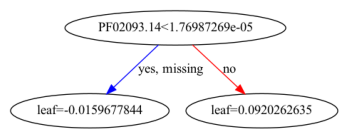

In [9]:
best_model = xgb.XGBClassifier(objective='multi:softmax',
                               eta=0.03)
best_model.fit(x_train,y_train['EMPO_3'])
print(best_model)
# plot single tree
plot_tree(best_model)
plt.show()

### Save fitted model

In [1]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
from joblib import dump

dump(best_model, '../model_joblibs/xgb_empo3.joblib')

NameError: name 'best_model' is not defined